# Implémentation du flow discret à travers le RealNVP

Papier de reference: https://arxiv.org/pdf/1605.08803

Le flow-matching est une évolution temporelle alors que que le flow discret du RealNVP est une suite d'étapes finies. Le modèle est défini par un nombre entier de couches :
$$x_0 → x_1 → x_2 → ... → x_k$$
$$z = f_k(...f_2(f_1(x)))$$

Pour prédire la trajectoire du flow on introduit les coupling layers.

On a besoin d'une fonction $f_x$ qui à certaines propriété:
- inversible : pour pouvoir gérer les données $x → y$ et $y → x$
- jacobienne : On doit pouvoir calculer le déterminant de sa matrice dérivée très vite pour entraîner le modèle via la formule du changement de variable.


### Coupling layers

 Au lieu de transformer tout le vecteur $x$ d'un coup (pas inversible), on coupe le vecteur en deux sous-vecteurs:
 - $x_1$ : Les dimensions $1$ à $d$ (ex: la première moitié des pixels).
 - $x_2$ : Les dimensions $d+1$ à $D$ (ex: la seconde moitié).

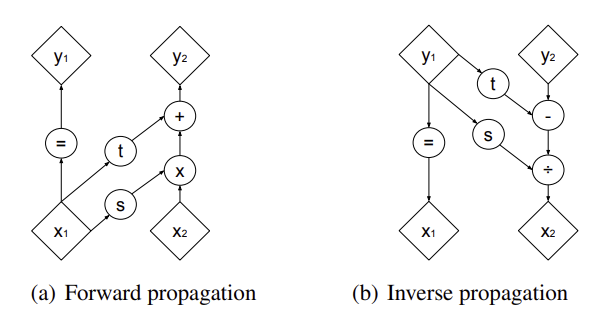

$s(\cdot)$ et $t(\cdot)$ sont des réseaux de neurones (dans notre exemple MLP). A noter: our inverser cette formule, on n'a pas besoin d'inverser les réseaux $s$ et $t$. Nous avons juste besoin de leur sortie.

### Simplification de la Jacobienne dans Real NVP

On doit calculer le déterminant de la matrice Jacobienne $J = \frac{\partial y}{\partial x}$.

Après la division des vecteurs en sous dimensions, on a :

$$
J = \begin{pmatrix}
\frac{\partial y_A}{\partial x_A} & \frac{\partial y_A}{\partial x_B} \\
\frac{\partial y_B}{\partial x_A} & \frac{\partial y_B}{\partial x_B}
\end{pmatrix}
$$

Si on analyse les 4 termes:

* $\left( \frac{\partial y_A}{\partial x_A} \right)$ : Comme $y_A = x_A$, la dérivée est la matrice **Identité** ($I$).
* $\left( \frac{\partial y_A}{\partial x_B} \right)$ : $y_A$ ne dépend absolument pas de $x_B$. La dérivée est **Zéro** ($0$).
* $\left( \frac{\partial y_B}{\partial x_A} \right)$ : c'est la dérivée des réseaux de neurones par rapport à l'entrée donc complexe mais on va pouvoir la mettre de côté.
* $\left( \frac{\partial y_B}{\partial x_B} \right)$ : On a $y_B = x_B \odot \exp(s(x_A)) + t(x_A)$, la dérivée par rapport à $x_B$ est juste le terme d'échelle : $\text{diag}(\exp(s(x_A)))$.

On se retrouve donc avec une matrice Jacobienne triangulaire inférieure:

$$
J = \begin{pmatrix}
I & 0 \\
\frac{\partial y_B}{\partial x_A} & \text{diag}(\exp(s(x_A)))
\end{pmatrix}
$$

On sait que (proptiété d'algèbre linéaire) le déterminant d'une matrice triangulaire est le produit de ses termes diagonaux.

$$
\det(J) = 1 \times \prod_i \exp(s(x_A)_i)
$$

En passant au logarithme (nécessaire pour la log-vraisemblance) :

$$
\log |\det(J)| = \sum_i \log(\exp(s(x_A)_i)) = \sum_i s(x_A)_i
$$

Le calcul du déterminant, qui est normalement une opération cubique monstrueuse ($O(D^3)$), devient une simple somme ($O(D)$). C'est cette astuce algébrique qui rend Real NVP entraînable.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from typing import Literal
from torch.utils.data import TensorDataset
from typing import Optional
import numpy as np


def get_2d_data(
    type: Literal["gaussian", "checkerboard"], n_samples: int = 10000
) -> TensorDataset:
    if type == "gaussian":
        # Mixture of 8 Gaussians arranged in a circle
        scale = 2.0
        centers = [
            (1, 0),
            (-1, 0),
            (0, 1),
            (0, -1),
            (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
            (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
            (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
            (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        ]
        centers = [(scale * x, scale * y) for x, y in centers]
        dataset = []
        for i in range(n_samples):
            point = np.random.randn(2) * 0.5
            center = centers[np.random.choice(len(centers))]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414  # Normalize to [-2, 2] -> [-1.5, 1.5] range

        return TensorDataset(torch.from_numpy(dataset))

    elif type == "spirals":
        n = np.sqrt(np.random.rand(n_samples // 2)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n + np.random.rand(n_samples // 2) * 0.5
        d1y = np.sin(n) * n + np.random.rand(n_samples // 2) * 0.5
        x = np.vstack((np.hstack((d1x, -d1x)), np.hstack((d1y, -d1y)))).T
        x = x / 5
        x = x + np.random.randn(*x.shape) * 0.05
        return TensorDataset(torch.from_numpy(x.astype("float32")))

    elif type == "checkerboard":
        x1 = np.random.rand(n_samples) * 4 - 2
        x2_ = np.random.rand(n_samples) - np.random.randint(0, 2, n_samples) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        dataset = np.stack([x1, x2 * 2], axis=1).astype("float32")
        # Normalize to be centered and scaled
        dataset = dataset / 2.0
        return TensorDataset(torch.from_numpy(dataset))

    else:
        raise ValueError(f"Unknown 2d data type: {type}")

Training start
Iter 0, Loss: 1.3360
Iter 500, Loss: -0.4506
Iter 1000, Loss: -0.5545
Iter 1500, Loss: -0.5910
Iter 2000, Loss: -0.6084


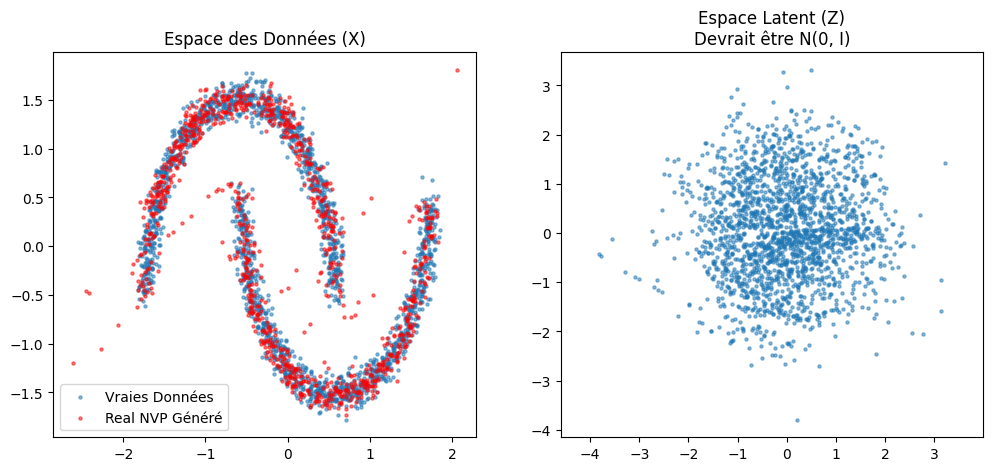

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

class Nets(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        # taille 2 en sortie, une pour s, une pour t
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.net(x)

class RealNVP_Coupling(nn.Module):
    def __init__(self, mask, hidden_dim=32):
        super().__init__()
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.st_net = Nets(hidden_dim)

    def forward(self, x):
        # on separe ce qu'on garde (masked) de ce qu'on change
        x_masked = x * self.mask

        # on passe juste la dimension active au réseau
        if self.mask[0] == 1:
          input_feature = x[:, 0].unsqueeze(1)
        else:
          input_feature = x[:, 1].unsqueeze(1)

        st = self.st_net(input_feature)
        s, t = st[:, 0].unsqueeze(1), st[:, 1].unsqueeze(1)

        s = torch.tanh(s)

        # y = x_frozen + (x_to_change * exp(s) + t)
        x_out = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)

        # log det jacob -> 1D donc juste s
        log_det_J = torch.sum(s, dim=1)

        return x_out, log_det_J

    def inverse(self, z):
        z_masked = z * self.mask
        if self.mask[0] == 1:
          input_feature = z[:, 0].unsqueeze(1)
        else:
          input_feature = z[:, 1].unsqueeze(1)

        st = self.st_net(input_feature)
        s, t = st[:, 0].unsqueeze(1), st[:, 1].unsqueeze(1)
        s = torch.tanh(s)

        # x = (y - t) * exp(-s)
        z_out = z_masked + (1 - self.mask) * ((z - t) * torch.exp(-s))
        return z_out

class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()
        # 6 fois donc on a 3 vrais blocs
        self.layers = nn.ModuleList([
            RealNVP_Coupling(torch.tensor([1., 0.]), hidden_dim=64),
            RealNVP_Coupling(torch.tensor([0., 1.]), hidden_dim=64),
            RealNVP_Coupling(torch.tensor([1., 0.]), hidden_dim=64),
            RealNVP_Coupling(torch.tensor([0., 1.]), hidden_dim=64),
            RealNVP_Coupling(torch.tensor([1., 0.]), hidden_dim=64),
            RealNVP_Coupling(torch.tensor([0., 1.]), hidden_dim=64),
        ])

    def forward(self, x):
        log_det_sum = 0
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_sum += log_det
        return x, log_det_sum

    def sample(self, num_samples):
        # echantillonner depuis la prior
        z = torch.randn(num_samples, 2)
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

"""
data, _ = make_moons(n_samples=2000, noise=0.05)
data = torch.tensor(data, dtype=torch.float32)
data = (data - data.mean(0)) / data.std(0)

model = RealNVP()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Training start")
for i in range(2001):
    optimizer.zero_grad()

    # Forward pass : x -> z
    z, log_det = model(data)

    # Loss: Negative Log-Likelihood
    # NLL = - (log p_z(z) + log |det J|)
    # p_z est une gaussienne standard: log p_z = -0.5 * z^2 - const
    prior_ll = -0.5 * torch.sum(z**2, dim=1)
    # (on ignore la constante pi car elle ne change pas le gradient)

    loss = -torch.mean(prior_ll + log_det)

    loss.backward()
    optimizer.step()

    if i % 500 == 0:
        print(f"Iter {i}, Loss: {loss.item():.4f}")

# ==========================================
# 5. Visualisation
# ==========================================
model.eval()
with torch.no_grad():
    # 1. Génération (Inverse Flow)
    samples = model.sample(1000).numpy()

    # 2. Densité latente (Forward Flow)
    z_transformed, _ = model(data)
    z_transformed = z_transformed.numpy()

plt.figure(figsize=(12, 5))

# Données réelles vs Générées
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], s=5, label='Vraies Données', alpha=0.5)
plt.scatter(samples[:, 0], samples[:, 1], s=5, label='Real NVP Généré', color='red', alpha=0.5)
plt.title("Espace des Données (X)")
plt.legend()

# Espace Latent (Devrait être une Gaussienne ronde)
plt.subplot(1, 2, 2)
plt.scatter(z_transformed[:, 0], z_transformed[:, 1], s=5, alpha=0.5)
plt.title("Espace Latent (Z)\nDevrait être N(0, I)")
plt.axis('equal')

plt.show()"""

Training start on checkerboard dataset...
Iter 0, Loss (NLL): 0.9554
Iter 500, Loss (NLL): -0.1202
Iter 1000, Loss (NLL): -0.1795
Iter 1500, Loss (NLL): -0.2061
Iter 2000, Loss (NLL): -0.2324
Iter 2500, Loss (NLL): -0.2562
Iter 3000, Loss (NLL): -0.2329
Iter 3500, Loss (NLL): -0.2729
Iter 4000, Loss (NLL): -0.2724
Iter 4500, Loss (NLL): -0.3022
Iter 5000, Loss (NLL): -0.2943
Iter 5500, Loss (NLL): -0.3135
Iter 6000, Loss (NLL): -0.3123
Iter 6500, Loss (NLL): -0.3223
Iter 7000, Loss (NLL): -0.3283
Iter 7500, Loss (NLL): -0.3240
Iter 8000, Loss (NLL): -0.3105
Iter 8500, Loss (NLL): -0.3335
Iter 9000, Loss (NLL): -0.3173
Iter 9500, Loss (NLL): -0.3311
Iter 10000, Loss (NLL): -0.3565
Iter 10500, Loss (NLL): -0.3539
Iter 11000, Loss (NLL): -0.3339
Iter 11500, Loss (NLL): -0.3675
Iter 12000, Loss (NLL): -0.3619
Iter 12500, Loss (NLL): -0.3489
Iter 13000, Loss (NLL): -0.3666
Iter 13500, Loss (NLL): -0.3709
Iter 14000, Loss (NLL): -0.3850
Iter 14500, Loss (NLL): -0.3801
Iter 15000, Loss (NLL):

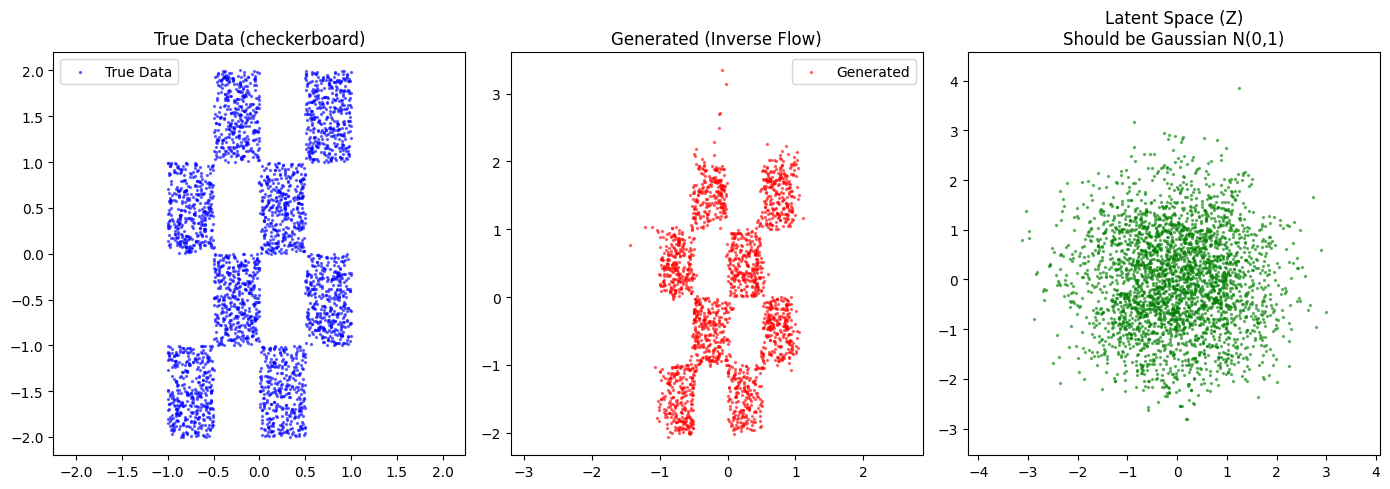

In [ ]:
DATA_TYPE = "checkerboard"
dataset_obj = get_2d_data(type=DATA_TYPE, n_samples=3000)

# Extract the tensor from the TensorDataset
data = dataset_obj.tensors[0]

# Note: Your get_2d_data function already normalizes the data nicely.
# We do not need extra mean/std normalization here.

# ==========================================
# 4. Training
# ==========================================
model = RealNVP()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"Training start on {DATA_TYPE} dataset...")
loss_history = []

for i in range(20001):
    optimizer.zero_grad()

    # Forward pass : x -> z
    z, log_det = model(data)

    # Loss: Negative Log-Likelihood
    # NLL = - (log p_z(z) + log |det J|)
    # p_z is standard normal: log p_z = -0.5 * z^2 - const
    prior_ll = -0.5 * torch.sum(z**2, dim=1)

    # Mean NLL over the batch
    loss = -torch.mean(prior_ll + log_det)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if i % 500 == 0:
        print(f"Iter {i}, Loss (NLL): {loss.item():.4f}")

# ==========================================
# 5. Metric: Final NLL
# ==========================================
model.eval()
with torch.no_grad():
    z_final, log_det_final = model(data)
    prior_ll_final = -0.5 * torch.sum(z_final**2, dim=1)
    # The exact NLL usually includes the log(2*pi) term, but for optimization
    # and comparison we often omit it. Here is the loss value:
    final_nll = -torch.mean(prior_ll_final + log_det_final).item()

print("="*30)
print(f"FINAL METRIC - Negative Log-Likelihood: {final_nll:.4f}")
print("="*30)

# ==========================================
# 6. Visualization
# ==========================================
#
with torch.no_grad():
    # 1. Generation (Inverse Flow)
    samples = model.sample(2000).numpy()

    # 2. Latent Density (Forward Flow)
    z_transformed, _ = model(data)
    z_transformed = z_transformed.numpy()

plt.figure(figsize=(14, 5))

# Real vs Generated Data
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], s=2, label='True Data', alpha=0.5, c='blue')
plt.title(f"True Data ({DATA_TYPE})")
plt.legend()
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.scatter(samples[:, 0], samples[:, 1], s=2, label='Generated', color='red', alpha=0.5)
plt.title("Generated (Inverse Flow)")
plt.legend()
plt.axis('equal')

# Latent Space
plt.subplot(1, 3, 3)
plt.scatter(z_transformed[:, 0], z_transformed[:, 1], s=2, alpha=0.5, c='green')
plt.title("Latent Space (Z)\nShould be Gaussian N(0,1)")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.axis('equal')

plt.tight_layout()
plt.show()

Training start on spirals dataset...
Iter 0, Loss (NLL): 1.2398
Iter 500, Loss (NLL): 0.2616
Iter 1000, Loss (NLL): 0.1355
Iter 1500, Loss (NLL): 0.0784
Iter 2000, Loss (NLL): 0.0452
Iter 2500, Loss (NLL): 0.0057
Iter 3000, Loss (NLL): -0.0070
Iter 3500, Loss (NLL): -0.0577
Iter 4000, Loss (NLL): -0.0722
Iter 4500, Loss (NLL): -0.0907
Iter 5000, Loss (NLL): -0.0993
Iter 5500, Loss (NLL): -0.1043
Iter 6000, Loss (NLL): -0.1185
Iter 6500, Loss (NLL): -0.0595
Iter 7000, Loss (NLL): -0.1401
Iter 7500, Loss (NLL): -0.1476
Iter 8000, Loss (NLL): -0.1476
Iter 8500, Loss (NLL): -0.1807
Iter 9000, Loss (NLL): -0.1917
Iter 9500, Loss (NLL): -0.1988
Iter 10000, Loss (NLL): -0.2011
Iter 10500, Loss (NLL): -0.2110
Iter 11000, Loss (NLL): -0.2121
Iter 11500, Loss (NLL): -0.2146
Iter 12000, Loss (NLL): -0.2290
Iter 12500, Loss (NLL): -0.2325
Iter 13000, Loss (NLL): -0.1839
Iter 13500, Loss (NLL): -0.2172
Iter 14000, Loss (NLL): -0.2309
Iter 14500, Loss (NLL): -0.2387
Iter 15000, Loss (NLL): -0.2292
I

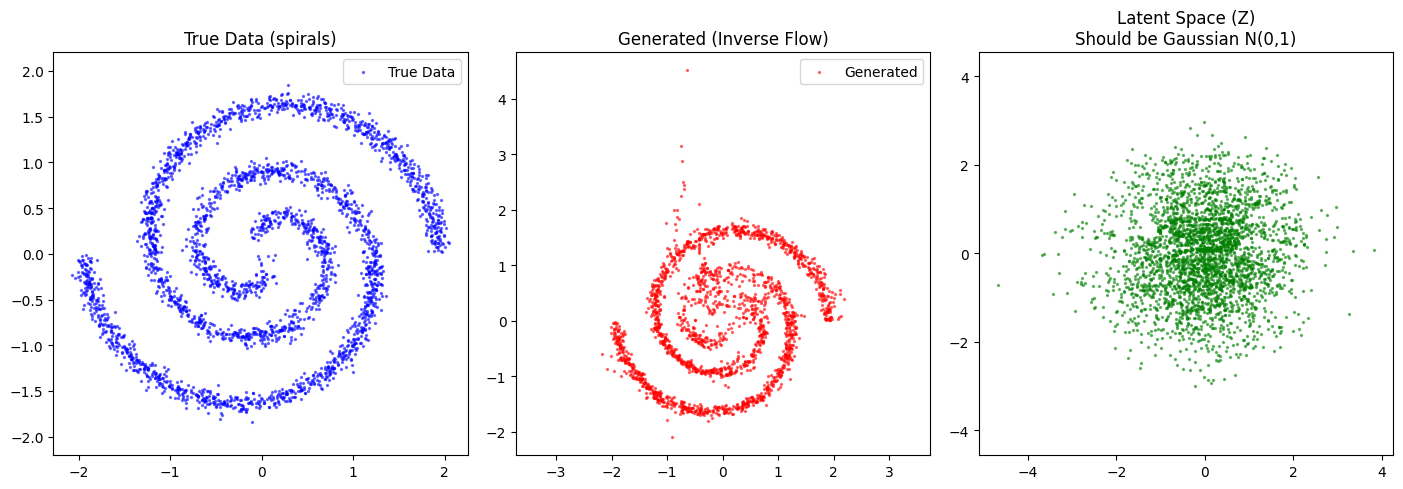

In [ ]:
DATA_TYPE = "spirals"
dataset_obj = get_2d_data(type=DATA_TYPE, n_samples=3000)

data = dataset_obj.tensors[0]

model = RealNVP()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"Training start on {DATA_TYPE} dataset...")
loss_history = []

for i in range(20001):
    optimizer.zero_grad()

    # Forward pass : x -> z
    z, log_det = model(data)

    # Loss: Negative Log-Likelihood
    # NLL = - (log p_z(z) + log |det J|)
    # p_z is standard normal: log p_z = -0.5 * z^2 - const
    prior_ll = -0.5 * torch.sum(z**2, dim=1)

    # Mean NLL over the batch
    loss = -torch.mean(prior_ll + log_det)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if i % 500 == 0:
        print(f"Iter {i}, Loss (NLL): {loss.item():.4f}")

model.eval()
with torch.no_grad():
    z_final, log_det_final = model(data)
    prior_ll_final = -0.5 * torch.sum(z_final**2, dim=1)
    # The exact NLL usually includes the log(2*pi) term, but for optimization
    # and comparison we often omit it. Here is the loss value:
    final_nll = -torch.mean(prior_ll_final + log_det_final).item()

print("="*30)
print(f"FINAL METRIC - Negative Log-Likelihood: {final_nll:.4f}")
print("="*30)

# ==========================================
# 6. Visualization
# ==========================================
#
with torch.no_grad():
    # 1. Generation (Inverse Flow)
    samples = model.sample(2000).numpy()

    # 2. Latent Density (Forward Flow)
    z_transformed, _ = model(data)
    z_transformed = z_transformed.numpy()

plt.figure(figsize=(14, 5))

# Real vs Generated Data
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], s=2, label='True Data', alpha=0.5, c='blue')
plt.title(f"True Data ({DATA_TYPE})")
plt.legend()
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.scatter(samples[:, 0], samples[:, 1], s=2, label='Generated', color='red', alpha=0.5)
plt.title("Generated (Inverse Flow)")
plt.legend()
plt.axis('equal')

# Latent Space
plt.subplot(1, 3, 3)
plt.scatter(z_transformed[:, 0], z_transformed[:, 1], s=2, alpha=0.5, c='green')
plt.title("Latent Space (Z)\nShould be Gaussian N(0,1)")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.axis('equal')

plt.tight_layout()
plt.show()